# Calculate density of intersections for a city

The process for calculating density of intersections for any city is:

- Grab the network data from OSM
- Convert the network to GeoDataframe
- Create a fishnet of ideally 500 sq. m. or 1 sq. km.
- Use spatial join to combine the two geo dataframes and then group the data by fishnet IDs.
 
With the spatial join, we're counting the number of intersection that intersect with the grid cell we created. That count gives the density of the intersections for the cell that can be visualized to create the density maps.

The functions plot the density graph along with intersections overlaid on fishnet.

In [1]:
## Importing packages

import osmnx as ox
from IPython.display import Image
from make_fishnet import make_fishnet
import shapely.speedups
import geocoder
from glob import glob
import geopandas as gpd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Getting the network data from OSM and creating a GDF from it

In [2]:
%%time
G = ox.graph_from_place('Piedmont, California', network_type='drive')
gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)

CPU times: user 1.78 s, sys: 4 ms, total: 1.78 s
Wall time: 17.8 s


### Plot the nodes

Text(0.5, 1.0, 'Intersections in Piedmont, CA')

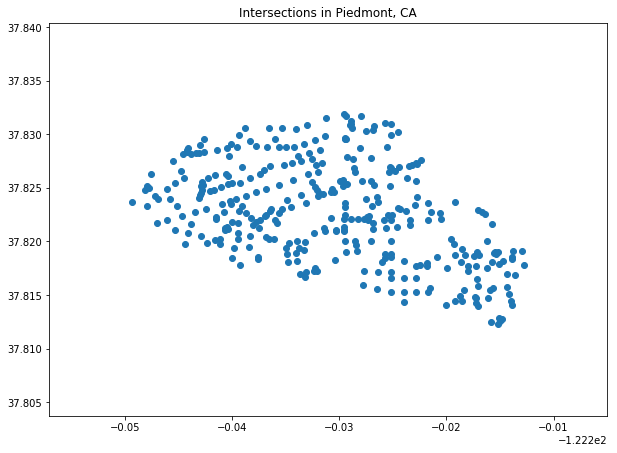

In [3]:
gdf.plot(figsize=[10,8])
pl.title('Intersections in Piedmont, CA')

### Geocode the place of interest to get the bounds for fishnet function

In [4]:
geo = geocoder.osm('Piedmont, California').geojson


xmin = geo['features'][0]['properties']['bbox'][0]
ymin = geo['features'][0]['properties']['bbox'][1]
xmax = geo['features'][0]['properties']['bbox'][2]
ymax = geo['features'][0]['properties']['bbox'][3]

string = 'Piedmont'

### Creating fishnet and reprojecting it to match that of geodataframe

In [5]:
make_fishnet('grid_data/Road_grid_{}.shp'.format(string), xmin,  xmax, ymin, ymax, 500, 500)
grid = gpd.GeoDataFrame.from_file('grid_data/Road_grid_{}.shp'.format(string))
grid.crs = {'init':'epsg:4326'}
grid = grid.to_crs(gdf.crs)

In [6]:
grid.head()

,FID,geometry
0,0,"POLYGON ((-122.249374 37.833026, -122.24488242..."
1,1,"POLYGON ((-122.249374 37.82734063060715, -122...."
2,2,"POLYGON ((-122.249374 37.82165526121431, -122...."
3,3,"POLYGON ((-122.249374 37.81596989182147, -122...."
4,4,"POLYGON ((-122.2448824235794 37.833026, -122.2..."


In [7]:
## Removing unwanted geometries from data

gdf = gdf.reset_index()

gdf = gdf.rename(columns ={'index':'id'})
gdf['geomType'] = gdf.geom_type
gdf = gdf[gdf['geomType'] != 'GeometryCollection']

In [9]:
## Merging the two shapefiles 

merged = gpd.sjoin( grid, gdf, how='left', op='intersects')

## Grouping the data by the FID of grid network
grp = merged.groupby('FID').count()

grid['node_count'] = grp.id

## Export the shapefile with roads fishnet
grid.to_file('{}_roads_fishnet.shp'.format(string))

/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Plot the outputs

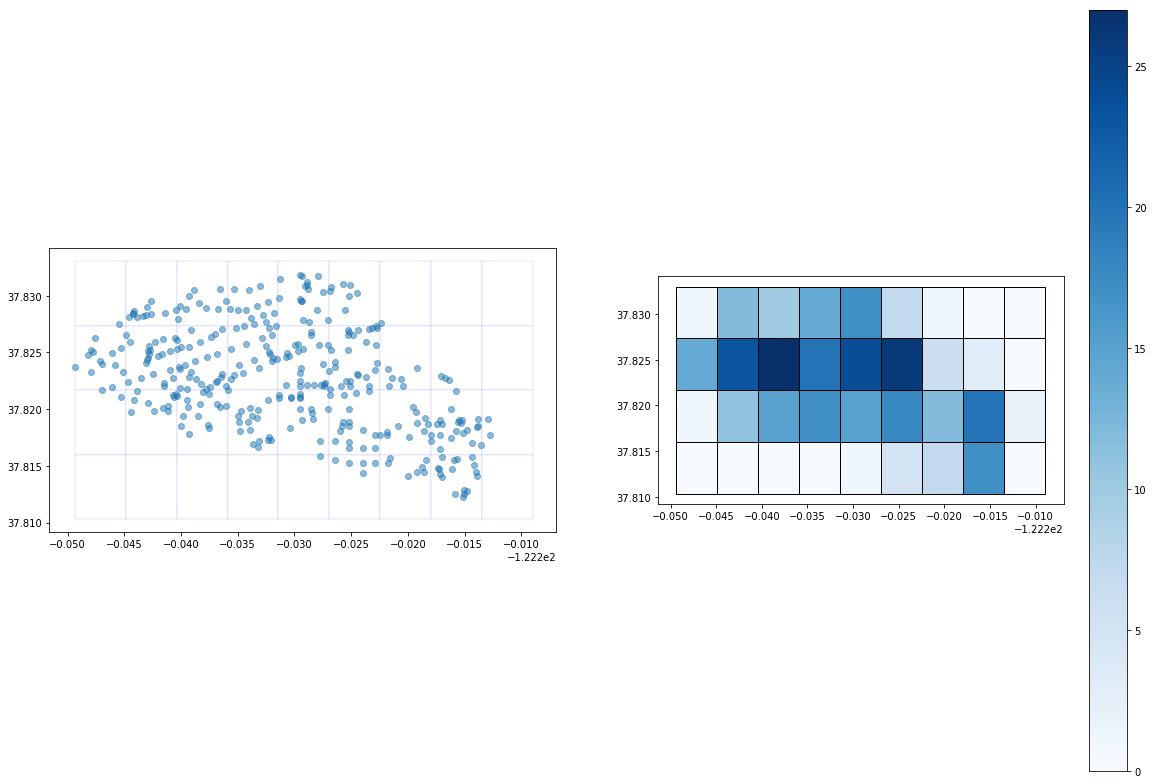

In [10]:
fig = pl.figure(figsize=(20,14))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
gdf.plot(ax=ax1, alpha=0.5);
grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)

In [14]:
gdf = ox.gdf_from_place('Lima')

In [15]:
gdf.geometry.bounds

,minx,miny,maxx,maxy
0,-77.088455,-12.07985,-77.001777,-12.03035


In [12]:
ox.graph_from_bbox(gdf.bbox_north, gdf.bbox_south, gdf.bbox_east, gdf.bbox_west)

In [16]:
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,-77.001777,-12.03035,-12.07985,-77.088455,"POLYGON ((-77.08845549999999 -12.0588313, -77....","Lima, Peru"


## Putting it all together

In [2]:
def get_polygon(string):
    
    lis = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/*/*.shp')
    
    city = []
    for i in lis:
        x = i.split('/')[-2]
        city.append(x.split('_')[0])
        
    if string in city:
        l = glob('/nfshome/gb1877/gb1877/WorldBank/CRP/Betweenness_Centrality/data/AOI/{}_AOI/*.shp'.format(string))
        adm = gpd.GeoDataFrame.from_file(l[0])
        boundary_poly = adm.geometry.values[0]
    else:
        boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=1)
        boundary_poly = boundary_GDF.loc[0,'geometry']
        if boundary_poly.geom_type == 'Polygon':
            boundary_poly = boundary_poly
        else:
            try:
                boundary_GDF = ox.gdf_from_place('{}'.format(string),which_result=2)
                boundary_poly = boundary_GDF.loc[0,'geometry']
            except:
                return -1
    
    return boundary_poly

In [3]:
def get_graph(place):
    string = place.split(',')[0]
    
    print('Fetching graph data for {}'.format(place))
    
    poly = get_polygon(string)
    
    if poly == -1:
        gdf = ox.gdf_from_place('{}'.format(string))
        G = ox.graph_from_bbox(gdf.bbox_north, gdf.bbox_south, gdf.bbox_east, gdf.bbox_west)
    else:
        G = ox.graph_from_polygon(poly, network_type='drive')

    G = ox.project_graph(G)
    
    return G

In [4]:
def get_node_count(place_name, pixel_size=None):
    
    ## Setting initial crs
    crs = {'init':'epsg:4326'}
    
    string = place_name.split(',')[0]
    
    print('Fetching network data from OSM for {}'.format(place_name))
    
    ## Grabbing data from OSM
    G = get_graph(place_name)
    
    gdf_proj = ox.graph_to_gdfs(G, nodes=True, edges=False)
    
    ## Geocoding the city for fishnet grid
    #if geocode == 'arcgis':
    #    geo = geocoder.arcgis(place_name)
    #    xmin = geo.geojson['features'][0]['properties']['raw']['extent']['xmin']
    #    ymin = geo.geojson['features'][0]['properties']['raw']['extent']['ymin']
    #    xmax = geo.geojson['features'][0]['properties']['raw']['extent']['xmax']
    #    ymax = geo.geojson['features'][0]['properties']['raw']['extent']['ymax']
    #else:
    #    geo = geocoder.osm(place_name).geojson
    #    xmin = geo['features'][0]['properties']['bbox'][0]
    #    ymin = geo['features'][0]['properties']['bbox'][1]
    #    xmax = geo['features'][0]['properties']['bbox'][2]
    #    ymax = geo['features'][0]['properties']['bbox'][3]
    
    gdf = ox.gdf_from_place('{}'.format(string))
    
    if pixel_size is not None:
        size = pixel_size
    else:
        size = 500
    
    print('Creating fishnet')
    
    ## Creating fishnet and exporting the file
    
    make_fishnet('grid_data/Road_grid_{}.shp'.format(string), gdf.bbox_west,  gdf.bbox_east, gdf.bbox_south,
                 gdf.bbox_north, size, size)
    grid = gpd.GeoDataFrame.from_file('grid_data/Road_grid_{}.shp'.format(string))
    grid.crs = {'init':'epsg:4326'}
    grid = grid.to_crs(gdf_proj.crs)
    
    
    gdf_proj = gdf_proj.reset_index()
    
    ## Cleaning up the data by rmeoving invalid geometries
    
    gdf_proj = gdf_proj.rename(columns ={'index':'id'})
    gdf_proj['geomType'] = gdf_proj.geom_type
    gdf_proj = gdf_proj[gdf_proj['geomType'] != 'GeometryCollection']
    
    print('Merging datasets and calculating the count of nodes in each pixel')
    
    merged = gpd.sjoin( grid, gdf_proj, how='left', op='intersects')
    grp = merged.groupby('FID').count()
    
    grid['node_count'] = grp.id
    
    grid.to_file('RoadDensity/roads_density_shapefiles/{}_roads_fishnet.shp'.format(string)) ## Exporting fishnet file. This file has the data to plot
    
    
    #print('Plotting outputs')
    #fig = pl.figure(figsize=(20,14))
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)
    #grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
    #gdf_proj.plot(ax=ax1, alpha=0.5);
    #grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)
    
    ## Save footprints image
    #print('Saving output 1')
    #fig = pl.figure(figsize=(20,14))
    #ax = fig.add_subplot(111)
    #grid.plot(ax=ax, facecolor='w',edgecolor='b',lw=0.1)
    #gdf_proj.plot(ax=ax, alpha=0.5);

    #fig.savefig('RoadDensity/{}_overlay.png'.format(string))   # save the figure to file

    #pl.close(fig)
    
    ## Save density image
    #print('Saving output 2')
    #fig = pl.figure(figsize=(20,14))
    #ax2 = fig.add_subplot(111)
    #grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)

    #fig.savefig('RoadDensity/{}_density.png'.format(string))   # save the figure to file

    #pl.close(fig)
    
    ## Plot footprints and grid and Outputs
    #print('Saving output 3')
    #fig = pl.figure(figsize=(20,14))
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)
    #grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
    #gdf_proj.plot(ax=ax1, alpha=0.5);
    #grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)
    #fig.savefig('RoadDensity/{}_comparison.png'.format(string))   # save the figure to file
    #pl.close(fig)

### Piedmont, California

Fetching network data from OSM for Piedmont, California
Fetching graph data for Piedmont, California
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Saving output 1
CPU times: user 3.9 s, sys: 12 ms, total: 3.91 s
Wall time: 12.4 s


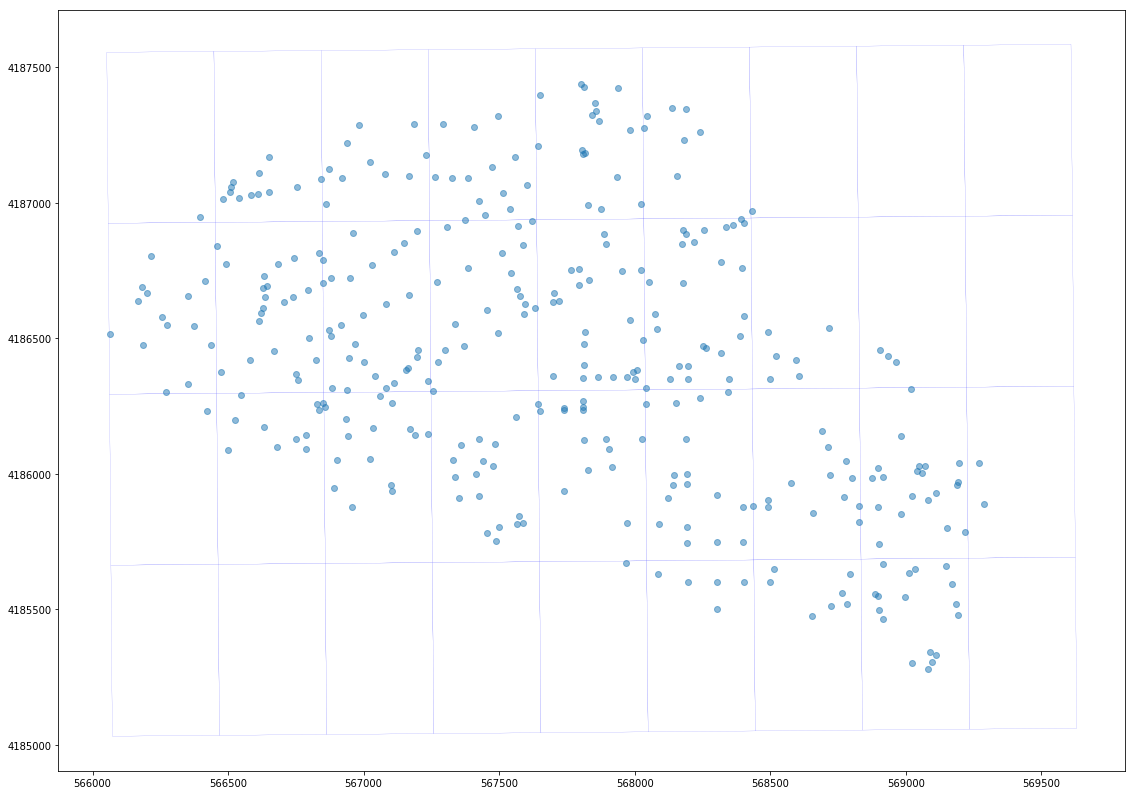

In [31]:
%%time

get_node_count('Piedmont, California')

### Darkhan, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 4.6 s, sys: 24 ms, total: 4.62 s
Wall time: 6.87 s


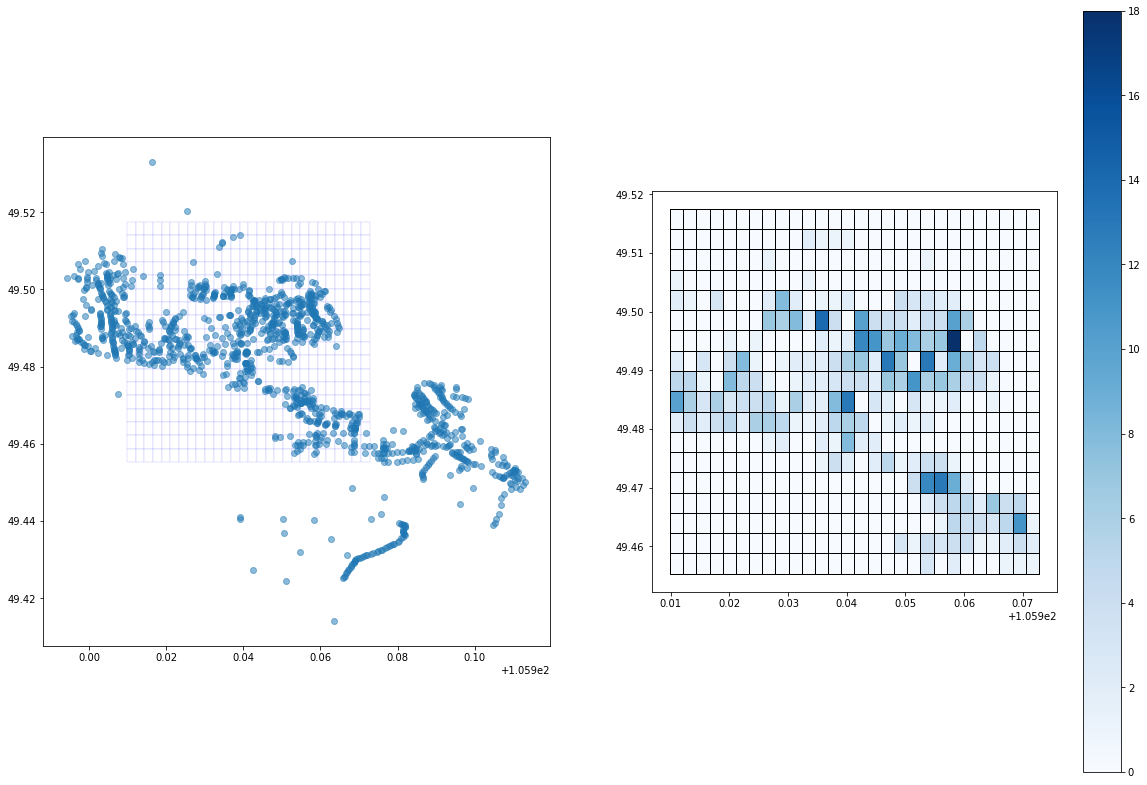

In [14]:
%%time

get_node_count('Darkhan, Mongolia', 250)

#### The extra data is because of improper geocoding. OSM geocoder doesn't work well for some places.

### Erdenet, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3


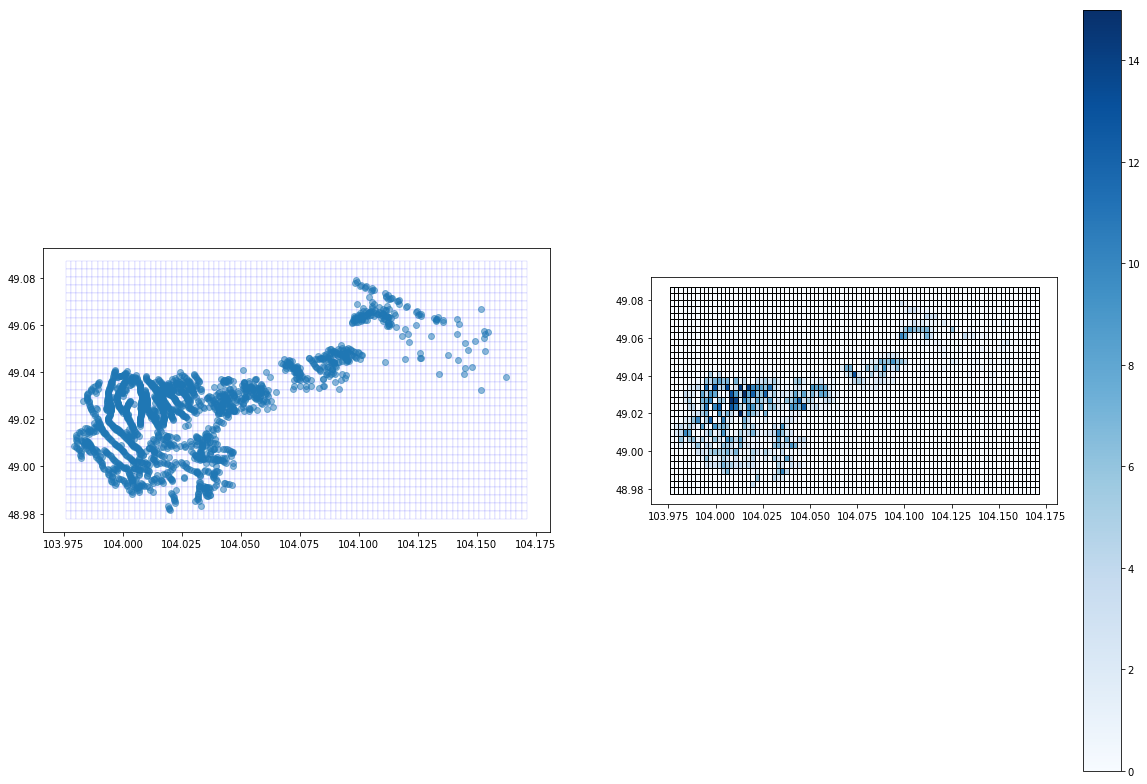

In [15]:
get_node_count('Erdenet, Mongolia', 250, geocode='osm')

### Ulannbaatar, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3


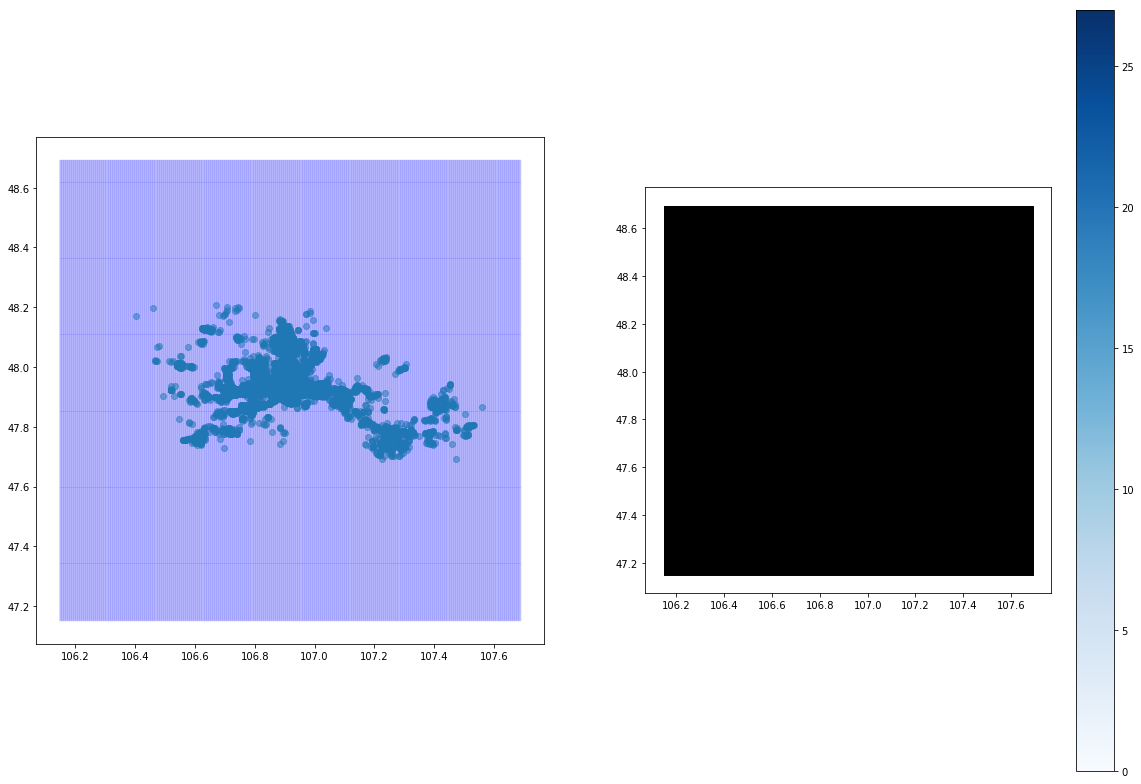

In [16]:
get_node_count('Ulaanbaatar, Mongolia', 250)

# CRP Cities

In [4]:
city_scan_list = [
    'Sfax, Tunisia',
'Sousse, Tunisia',
'Tunis, Tunisia',
'Batroun, Lebanon',
'Bint Jbeil, Lebanon',
'Joub Jannine, Lebanon',
#'West Bank', 
'Montevideo, Uruguay',
'Lima, Peru',
'Cap-Haitien, Haiti',
'Vinh Long, Vietnam',
'Khanh Hoa, Vietnam',
'Semarang, Indonesia',
'Penang, Malaysia',
'Tashkent, Uzbekistan',
'Osh,  Kyrgyzstan',
#Turkey (city TBD)
'Monrovia, Liberia',
'Johannesburg, South Africa',
'Maputo, Mozambique',
'Addis Ababa, Ethiopia',
'Blantyr, Malawi',
'St. Louis, Senegal',
'Cotonou, Benin',
'Accra, Ghana',
'El Nido, Philippines',
'Coron, Philippines',
'Puerto Princesa, Philippines',
'Davao City, Philippines'
    
]

In [ ]:
for i in city_scan_list[3:]:
    %time get_node_count(i, 250, geocode='osm')

Fetching network data from OSM for Batroun, Lebanon
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 2.79 s, sys: 12 ms, total: 2.8 s
Wall time: 5.85 s
Fetching network data from OSM for Bint Jbeil, Lebanon
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 1min 48s, sys: 1.99 s, total: 1min 50s
Wall time: 1min 55s
Fetching network data from OSM for Joub Jannine, Lebanon
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 45.3 s, sys: 500 ms, total: 45.8 s
Wall time: 50.1 s
Fetching network data from OSM for Montevideo, Uruguay
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 1min 12s, sys: 808 ms, total: 1min 13s
Wall time: 1min 17s
Fetching network data from OSM for Lim

In [4]:
city_scan_list = [
'Coron, Philippines',
'Puerto Princesa, Philippines',  
'El Nido, Philippines',
'Davao City, Philippines',
    'Tashkent, Uzbekistan',
    'Lima, Peru',
    'Vinh Long, Vietnam',
    'Khanh Hoa, Vietnam',
    'Osh,  Kyrgyzstan',
    'Monrovia, Liberia',
    'West Bank'
]

In [ ]:
for i in city_scan_list[-4:]:
     %time get_node_count(i, 250, geocode='osm')

Fetching network data from OSM for Khanh Hoa, Vietnam
Creating fishnet


Fetching network data from OSM for Tashkent, Uzbekistan
Fetching graph data for Tashkent, Uzbekistan
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Saving output 1
Saving output 2


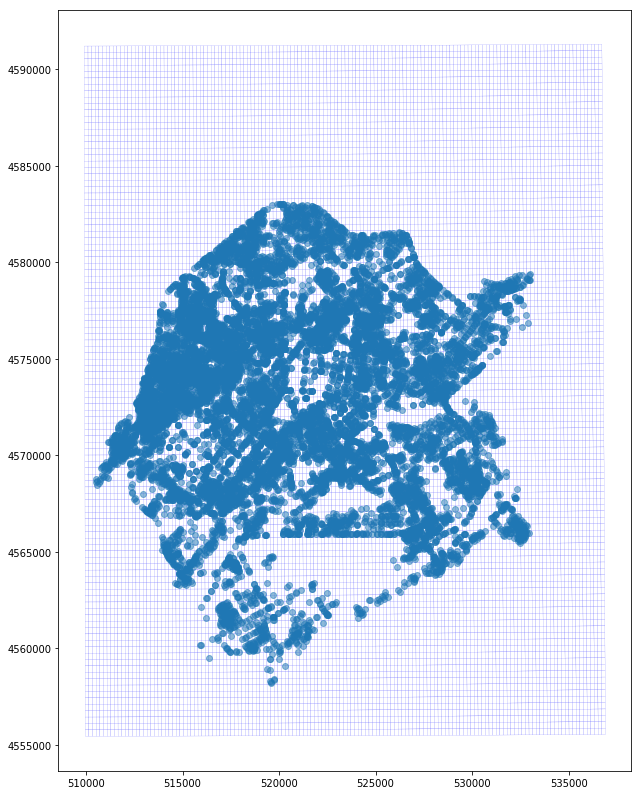

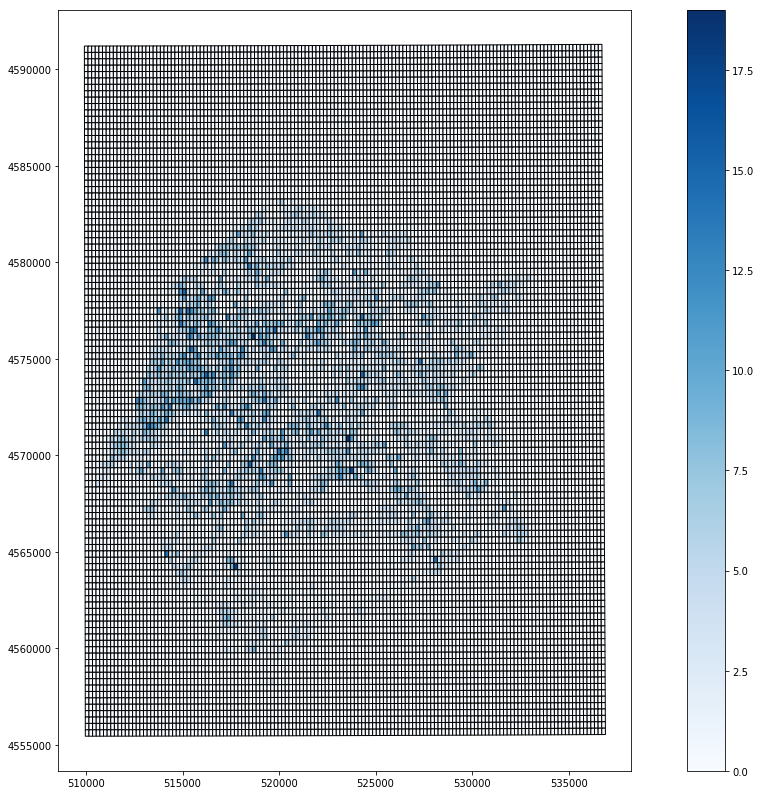

In [34]:
get_node_count('Tashkent, Uzbekistan', 250)

In [6]:
priority_list = [
    'Coron, Philippines', 'Puerto Princesa, Philippines', 'El Nido, Philippines', 'Davao City, Philippines', 
    'Tashkent, Uzbekistan' 'Hebron, West Bank', 'Bethlehem, West Bank', 'Lima, Peru', 'Vinh Long, Vietnam', 
    'Khanh Hoa, Vietnam', 'Osh, Kyrgyzstan', 'Monrovia, Liberia'
]

In [7]:
for i in priority_list[-2:]:
    %time get_node_count(i, 250)

Fetching network data from OSM for Osh, Kyrgyzstan
Fetching graph data for Osh, Kyrgyzstan
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel


/nfshome/gb1877/.conda/envs/osm3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


CPU times: user 33.7 s, sys: 920 ms, total: 34.6 s
Wall time: 36.5 s
Fetching network data from OSM for Monrovia, Liberia
Fetching graph data for Monrovia, Liberia
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
CPU times: user 1min 14s, sys: 1.53 s, total: 1min 16s
Wall time: 1min 18s


In [10]:
%time get_node_count('Hebron, West Bank', 250)

Fetching network data from OSM for Hebron, West Bank
Fetching graph data for Hebron, West Bank
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
CPU times: user 3min 35s, sys: 480 ms, total: 3min 36s
Wall time: 3min 37s


In [8]:
%time get_node_count('Penang, Malaysia', 250)

Fetching network data from OSM for Penang, Malaysia
Fetching graph data for Penang, Malaysia
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
CPU times: user 7min 54s, sys: 5.82 s, total: 8min
Wall time: 7min 58s


In [ ]:
%time get_node_count('Vinh Long, Vietnam', 250)

Fetching network data from OSM for Vinh Long, Vietnam
Fetching graph data for Vinh Long, Vietnam
Creating fishnet


In [9]:
%time get_node_count('Lima, Peru', 250)

Fetching network data from OSM for Lima, Peru
Fetching graph data for Lima, Peru
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
CPU times: user 12min 51s, sys: 3.45 s, total: 12min 54s
Wall time: 13min 13s


In [6]:
gdf = ox.gdf_from_place('{}'.format('Vinh Long, Vietnam'))

%time make_fishnet('grid_data/Road_grid_{}.shp'.format('Vinh Long'), gdf.bbox_west,  gdf.bbox_east, gdf.bbox_south,\
                 gdf.bbox_north, 250, 250)

CPU times: user 3min 10s, sys: 4min 40s, total: 7min 50s
Wall time: 7min 55s


In [8]:
%%time 

grid = gpd.read_file('grid_data/Road_grid_{}.shp'.format('Vinh Long'))
#grid.crs = {'init':'epsg:4326'}
#grid = grid.to_crs(gdf_proj.crs)


#gdf_proj = gdf_proj.reset_index()

## Cleaning up the data by rmeoving invalid geometries

#gdf_proj = gdf_proj.rename(columns ={'index':'id'})
#gdf_proj['geomType'] = gdf_proj.geom_type
#gdf_proj = gdf_proj[gdf_proj['geomType'] != 'GeometryCollection']

CPU times: user 2min 35s, sys: 48.7 s, total: 3min 24s
Wall time: 1h 9min 25s
